# Organizing, Subsetting and Processing Data

Now that you've successfully downloaded the GRACE and GLDAS data, you will need to read in and process the data to get groundwater anamoly estimates. Both datasets have raw data contained in .nc or .nc4 files. These are files for storing multi-dimensional data--in our case, the key dimensions we are interested in are latittude and longitude (geography) and time. We can use the `xarray` package to read in these data. 

## Reading in GRACE and GLDAS Data

Both datasets have similar processes for loading in the data which are outlined in detail below. However, the first step for processing both datasets is to filter to your region of interest. This is important because it makes processing times for each step much quicker. As such, our first step in processing will be loading in a shapefile and filtering to the region of interest before loading in GRACE and GLDAS and merging them with other datasets. 

### Subsetting The Data 

For most use cases, it will make the most sense to load in a shapefile and use this file to narrow down your region. This will allow your analysis to focus on your area of interest as precisely as possible and improve the efficiency of your code. If you don't have a shapefile or know your region of interest, you can pick any 4 latitude/longitude points and use them to draw a rectangle around a region of the world you are interested in. You can also skip this step, but note it will make the code take much longer to run. 

For our analysis here, we will use a shapefile that focuses on the Colorado River Basin. 

#### What is a Shapefile? 

A shapefile is a file that stores geometric location and attribute information of geographical features in a nontopological way. Shapefiles represent geographical features by points, lines, or polygons (geographical areas) (ArcGIS). It is one of the simpler ways to store and work with geographic data. Many shapefiles are publicly available for download by government agencies, researchers, or practitioners. Below is an example of what a shapefile looks like in tabular form and how you can go from that to a map.

<img src='images/shape%20file%20figure.png'>
Source: ReStore

#### Applying This Method to the CRB 

Below, we use this method to use a shapefile of the Colorado River Basin for analysis. You can download the shape file for the Colorado River Basin from ArcGIS hub [here](https://coloradoriverbasin-lincolninstitute.hub.arcgis.com/datasets/a198d1658b7741618e7d3732726cbc8f_0/explore?location=37.047204%2C-110.573590%2C6.53). After downloading the shapefiles, remember to **move them to the `data/shapefiles` folder** to run the code to read the shapefile. A visual of this is shown below: 

<img src='images/CRB_shapefile.png'>

To work with shapefiles, we will use the `geopandas` package, a spatial analysis package built on top of `pandas`. We will begin by loading in this package and reading in the shapefile. Next, we will load in plotting functions from `matplotlib` and map the shapefile. 

#### Dependencies

In [28]:
# import necessary packages and libraries 
import geopandas as gpd 
from shapely.geometry import box
import matplotlib.pyplot as plt
import pandas as pd 
import xarray as xr
import numpy as np
import os 
from datetime import datetime

#### Key variables

In [29]:
# Earth's radius
EARTH_RADIUS_KM = 6371
# Centimeters to kilometers
CM_TO_KM_RATIO = 1e-5
# Here, input the file path to the base data directory
BASE_DIR = '/home/akmehra/ongoingProjects/DSSG'
# Figure size
FIG_SIZE = (10, 10)

In [30]:
# Common functions

def add_labels(ax, title):
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title);

#### Loading in a shapefile

In [31]:
# Read the shapefile
basin_shapefile = gpd.read_file(os.path.join(BASE_DIR, "shapefiles/Colorado_River_Basin_Hydrological_Boundaries_with_Areas_served_by_Colorado_River.shp"))

A simple way to start narrowing down to the area within the Colorado River Basin is to construct a rectangle around the region and only read and process rows within that rectangle.

Below, we provide code to construct a bounding rectangle

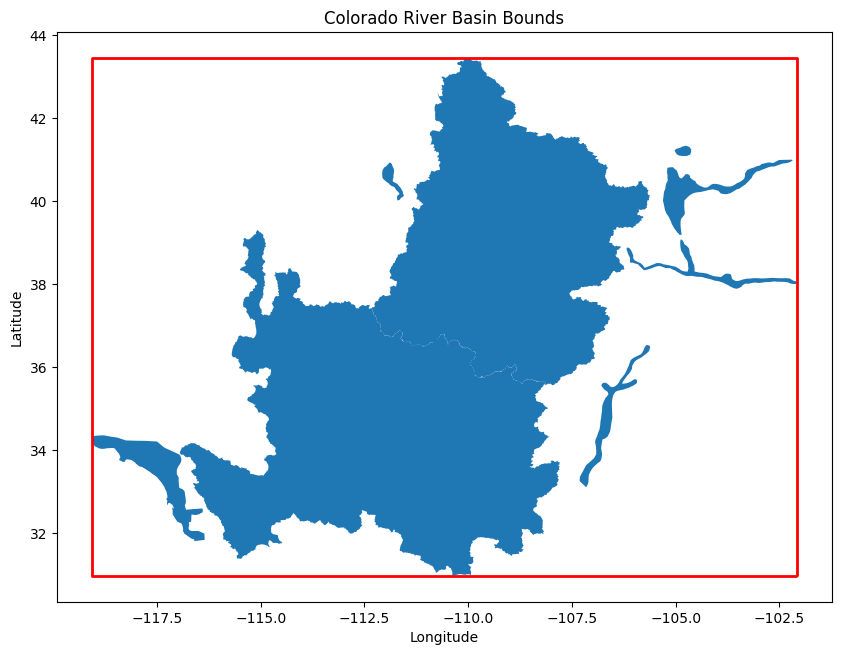

In [32]:
# We're using geopandas.GeoSeries.total_bounds.
[lon_min, lat_min, lon_max, lat_max] = basin_shapefile.total_bounds

# Here, we visualize the bounding box
# First, we create a GeoDataFrame with a single rectangle geometry
bounding_box = gpd.GeoDataFrame(geometry=[box(lon_min, lat_min, lon_max, lat_max)])
# Then, we plot both the basin shapefile and the bounding_box
fig, ax = plt.subplots(figsize=FIG_SIZE)
basin_shapefile.plot(ax=ax)
bounding_box.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

add_labels(ax, 'Colorado River Basin Bounds')


As you can see from the above plot, a substantial amount of geography not within the CRB is included within the bounding rectangle. 

Later on, we will use spatial processes to eliminate extraneous areas from our dataset. For now however, using the bounding rectangle will greatly speed up reading and applying other transformations to the data. 

#### Working with GRACE data

A single `.nc` file provides us with global land GRACE MASCON data. 

We will start by using `xarray` to read in the data. 

In [33]:
# Here, we load in GRACE data.
grace = xr.open_dataset(os.path.join(BASE_DIR, "GRACE_MASCON/data/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06.1_V3/GRCTellus.JPL.200204_202304.GLO.RL06.1M.MSCNv03CRI.nc"))

# Print out GRACE data. Note that our variable of interest (lwe_thickness) is measured in centimeters.
grace

<xarray.Dataset>
Dimensions:        (lon: 720, lat: 360, time: 220, bounds: 2)
Coordinates:
  * lon            (lon) float64 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2002-04-17T12:00:00 ... 2023-04-16
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (time, lat, lon) float64 ...
    uncertainty    (time, lat, lon) float64 ...
    lat_bounds     (lat, bounds) float64 ...
    lon_bounds     (lon, bounds) float64 ...
    time_bounds    (time, bounds) datetime64[ns] ...
    land_mask      (lat, lon) float64 ...
    scale_factor   (lat, lon) float64 ...
    mascon_ID      (lat, lon) float64 ...
Attributes: (12/53)
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06.1Mv03 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    ...                            ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    date_created:                  2023-06-28T21:06:45Z

The first thing you will note is that the dataset has several dimensions: `lon`, `lat`, `time`, and `bounds`. These dimensions exist because the GRACE data come at the pixel-level for each year. In this situation, a pixel is the smallest geographic unit of analysis. Because collecting and processing GRACE satellite data is technical and computationally expensive, GRACE measurements are given as .5-degree by .5-degree squares. The pixels cover Earth's entire surface and each have a GRACE measurement monthly from 2002-present. A visual of this is shown below, where each square in the grid corresponds to a pixel (Sharma, Patnaik, Biswal, Reager, 2020). Note that the yellow dots are gauging stations for comparison. 

<p align="center">
    <img src="images/GRACE_grids.png" width="500" />
</p>

We begin by transforming the dataset into a pandas dataframe. For the sake of efficiency, we select only the variables needed for future analyses. Additionally, to aid working with other spatial datasets, we will transform the longitude points from a [0,360] range to a [-180,180] range.  

Remember that each latitude and longitude serves as the center of a pixel. Any associated values are not representative of this exact point in space, but rather the entire pixel that the point is a center of. 

Though not necessary for our analysess, if one wanted to get the coordinates of each of the four corners, they would just have to add and subtract the pixel length divided by 2 to each latitude and longitude value. 

In [34]:
# A function that converts longitude from 0-360 to -180-180
def convert_longitude(lon):
    if lon >= 180:
        return lon - 360
    else:
        return lon

In [36]:
# Only extracting the variables we need from the grace dataset, after which we convert everything into a dataframe.
grace_df = grace[['lon','lat','time','lwe_thickness','uncertainty','scale_factor']].to_dataframe()
# Expanding the entries (i.e., every lon lat combo has multiple times, thicknesses, and uncertainties, which we would like to be unique rows)
grace_df.reset_index(inplace=True)
# Relabel the columns to include units
grace_df = grace_df.rename(columns={'lwe_thickness': 'lwe_thickness_cm', 'uncertainty': 'uncertainty_cm'})
# Convert longitude values
grace_df['lon'] = grace_df['lon'].apply(convert_longitude)
# How many duplicates exist?
"There are %s duplicate rows" % grace_df.duplicated().sum()
# Next, we subset the data to only include pixels within the bounding rectangle
grace_df = grace_df[(grace_df.lon > lon_min) & (grace_df.lon < lon_max) & (grace_df.lat > lat_min) & (grace_df.lat < lat_max)]
# Finally, we sort using the time column
grace_df.sort_values(by='time', inplace=True)


In [37]:
# View the GRACE dataframe
grace_df

,lon,lat,time,lwe_thickness_cm,uncertainty_cm,scale_factor
38227640,-118.75,31.25,2002-04-17 12:00:00,-0.378444,3.706507,NaN
39970480,-107.75,32.25,2002-04-17 12:00:00,-0.578217,5.456031,0.589973
39970700,-107.75,32.75,2002-04-17 12:00:00,-0.578217,5.456031,0.589973
39970920,-107.75,33.25,2002-04-17 12:00:00,-0.578217,5.456031,0.647506
39971140,-107.75,33.75,2002-04-17 12:00:00,-0.578217,5.456031,0.647506
...,...,...,...,...,...,...
39972019,-107.75,35.25,2023-04-16 00:00:00,2.646165,3.898687,0.694992
39971799,-107.75,34.75,2023-04-16 00:00:00,2.646165,3.898687,0.373176
39971579,-107.75,34.25,2023-04-16 00:00:00,-14.812561,5.080677,0.545095
40050559,-107.25,33.75,2023-04-16 00:00:00,-14.812561,5.080677,0.647506


#### Scaling and unit conversion

The last step in processing GRACE data is to first convert the units of `lwe_thickness`, or terrestrial water storage, and then multiply the resulting values by a scale factor. 

The scale factor (unique to each pixel) is intended to restore much of the energy that is removed due the sampling and post-processing of GRACE observations. More information about the scaling factors can be found [here](https://grace.jpl.nasa.gov/data/get-data/monthly-mass-grids-land/). 

**Note that NASA states users should multiply the data by the scaling coefficient, so it is imperative not to skip this step**. 

The original terrestrial water storage is measured in $cm$.  We convert those measurements to $km^3$ by:

1. Transforming terrestrial water storage units from $cm$ to $km$ by multiplying the reported value by the `CM_TO_KM_RATIO`. 
2. Multiplying the resulting $km$ value by the *surface area* of each pixel (in $km^2$).

We multiply the converted value by the `scale_factor` provided for each pixel. 

In the following code, we also convert the unit of uncertainty from $cm$ to $km^3$. We document how to incorporate uncertainty on the [Understanding Uncertainty in Groundwater Calculation](./06-Understanding%20Uncertainty.md) page.

In [163]:
# Compute surface area for pixel with dimensions n x n degree. Note the area of a pixel changes with respect to latitude!
degree_measure = 0.5
grace_df['surface_area_km2'] = EARTH_RADIUS_KM * np.radians(degree_measure) * EARTH_RADIUS_KM * np.radians(degree_measure) * np.cos(np.radians(grace_df['lat']))

# Convert units from cm to km^3
grace_df["lwe_thickness_km3"] = grace_df["lwe_thickness_cm"]  * CM_TO_KM_RATIO * grace_df['surface_area_km2'] * grace_df['scale_factor']
grace_df['uncertainty_km3'] = grace_df["uncertainty_cm"] * CM_TO_KM_RATIO * grace_df['surface_area_km2']

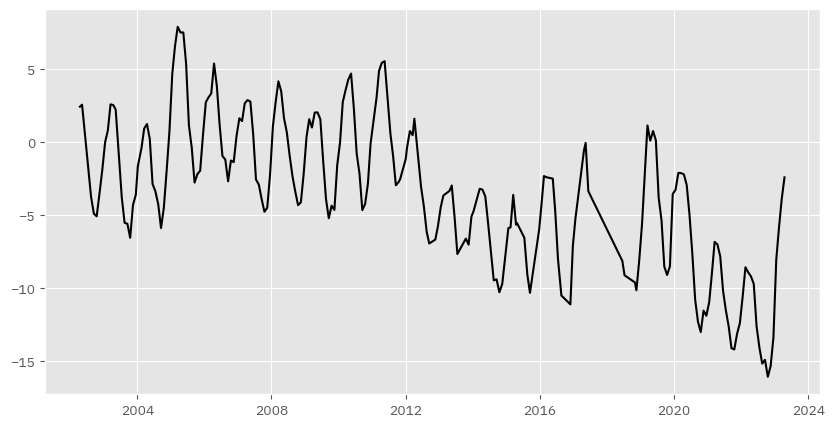

In [184]:
# Use IBM Plex when possible
plt.rcParams['font.family'] = 'IBM Plex Sans'

fig, ax = plt.subplots(figsize=(10, 5))

grouped = grace_df.groupby(['time']).mean()
grouped = grouped.reset_index()


# Filter the dataframe to include only the required dates to calculate average
TIME_PERIOD_START = '2003-01-01'
TIME_PERIOD_END = '2014-01-01'

mask = (grouped['time'] >= TIME_PERIOD_START) & (grouped['time'] <= TIME_PERIOD_END)
filtered_df = grouped.loc[mask]


ax.plot(grouped['time'], grouped['lwe_thickness_cm'], color='black')

### GLDAS Data 

Next, we will read in the GLDAS data which provides us with information on snow pack and soil moisture. These data are similarly in a multidimensional data format which can be read in using `xarray`. However, the data come in individual files that require being read in and combined into one dataset. The code below does this. 

In [39]:
# Read in one file of the GLDAS data as a demonstration
# Note the interested variables "SWE_inst" and "RootMoist_inst" are measured in kilogram per square meter (kg/m2)

xr.open_dataset(os.path.join(BASE_DIR, "GLDAS/NOAH_monthly_L4/GLDAS_NOAH025_M.A200001.021.nc4"))

<xarray.Dataset>
Dimensions:                (time: 1, bnds: 2, lon: 1440, lat: 600)
Coordinates:
  * time                   (time) datetime64[ns] 2000-01-01
  * lon                    (lon) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
  * lat                    (lat) float32 -59.88 -59.62 -59.38 ... 89.62 89.88
Dimensions without coordinates: bnds
Data variables: (12/37)
    time_bnds              (time, bnds) datetime64[ns] ...
    Swnet_tavg             (time, lat, lon) float32 ...
    Lwnet_tavg             (time, lat, lon) float32 ...
    Qle_tavg               (time, lat, lon) float32 ...
    Qh_tavg                (time, lat, lon) float32 ...
    Qg_tavg                (time, lat, lon) float32 ...
    ...                     ...
    Rainf_f_tavg           (time, lat, lon) float32 ...
    Tair_f_inst            (time, lat, lon) float32 ...
    Qair_f_inst            (time, lat, lon) float32 ...
    Psurf_f_inst           (time, lat, lon) float32 ...
    SWdown_f_tavg          (time, lat, lon) float32 ...
    LWdown_f_tavg          (time, lat, lon) float32 ...
Attributes: (12/19)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    Conventions:            CF-1.6
    history:                created on date: 2019-09-17T14:58:21.836
    source:                 Noah_v3.6 forced with GDAS-AGRMET-GPCPv13rA1
    institution:            NASA GSFC
    missing_value:          -9999.0
    ...                     ...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  -59.875
    SOUTH_WEST_CORNER_LON:  -179.875
    DX:                     0.25
    DY:                     0.25
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [40]:
### import GLDAS data, filter to CRB, combine into one dataframe 

gldas_path = os.path.join(BASE_DIR, "GLDAS/NOAH_monthly_L4/")

gldas_df = pd.DataFrame()

#Iterating through files in path
for filename in os.listdir(gldas_path):
    
    if filename.endswith(".nc4"):
        
        #Reading in data as xarray then converting to DataFrame
        xd = xr.open_dataset(gldas_path+str(filename))
        xd_df = xd.to_dataframe()

        xd_df.reset_index(inplace=True)

        xd_df = xd_df[(xd_df.lon> lon_min) & (xd_df.lon < lon_max)]
        xd_df = xd_df[(xd_df.lat> lat_min) & (xd_df.lat < lat_max)]

        #Extracting only needed columns 
        df_slice = xd_df[["time", "lon", "lat", "SWE_inst", "RootMoist_inst"]]
        df_slice = df_slice.drop_duplicates()

        gldas_df = pd.concat([gldas_df, df_slice], axis=0)

gldas_df = gldas_df.rename(columns={'SWE_inst': 'SWE_inst_kg/m2', 'RootMoist_inst': 'RootMoist_inst_kg/m2'})

In the following code, we are changing the units of Soil Moisture and Snow Water Equivalent, originally reported in $\frac{kg}{m^2}$, to $km^3$.

We do so by:

1. Multiplying each data point by 1,000,000, which turns the value into $\frac{kg}{km^2}$.
2. Multiplying each data point by the surface area of each pixel---measured in {km^2}--to get kg.
3. Multiplying the data by $1*10^{-12}$ to get $km^3$. Since, at standard temperature and pressure, water has density of 1 $\frac{kg}{liter}$, 1 kg water = 1 liter = $1*10^{-12}$ $km^3$.  

In [41]:
# Compute surface area for pixel with dimension 0.25 x 0.25 degree. 
gldas_df['surface_area_km2_0.25'] = EARTH_RADIUS_KM * np.radians(.25) * EARTH_RADIUS_KM * np.radians(.25) * np.cos(np.radians(gldas_df['lat']))

# Converting units from kg/m2 to km3
KG_PER_M2_TO_KG_PER_KM2_RATIO = 1e6
KG_TO_KM3_RATIO = 1e-12


gldas_df['RootMoist_inst_km3'] = gldas_df['RootMoist_inst_kg/m2'] * KG_PER_M2_TO_KG_PER_KM2_RATIO * gldas_df['surface_area_km2_0.25'] * KG_TO_KM3_RATIO
gldas_df['SWE_inst_km3'] = gldas_df['SWE_inst_kg/m2'] * KG_PER_M2_TO_KG_PER_KM2_RATIO * gldas_df['surface_area_km2_0.25'] * KG_TO_KM3_RATIO
gldas_df

,time,lon,lat,SWE_inst_kg/m2,RootMoist_inst_kg/m2,surface_area_km2_0.25,RootMoist_inst_km3,SWE_inst_km3
1048808,2023-03-01,-118.875,31.125,NaN,NaN,661.522827,NaN,NaN
1048810,2023-03-01,-118.625,31.125,NaN,NaN,661.522827,NaN,NaN
1048812,2023-03-01,-118.375,31.125,NaN,NaN,661.522827,NaN,NaN
1048814,2023-03-01,-118.125,31.125,NaN,NaN,661.522827,NaN,NaN
1048816,2023-03-01,-117.875,31.125,NaN,NaN,661.522827,NaN,NaN
...,...,...,...,...,...,...,...,...
187009,2000-01-01,-102.125,42.375,0.668583,72.323608,570.883057,0.041288,0.000382
187010,2000-01-01,-102.125,42.625,0.551255,71.502670,568.605042,0.040657,0.000313
187011,2000-01-01,-102.125,42.875,0.551538,64.827583,566.316284,0.036713,0.000312
187012,2000-01-01,-102.125,43.125,0.763360,169.107285,564.016724,0.095379,0.000431


### Focusing on the Basin 

Returning to the GRACE data, we saw earlier that though the data is filtered down to a rectangle containing the Colorado River Basin, there are still areas that are not contained in the rectangle. We can use geoprocessing techniques from `geopandas` to keep points in GRACE that only intersect the shape file. 

In [42]:
# Create a GeoDataFrame directly from grace_df
grace_gdf = gpd.GeoDataFrame(grace_df, 
                              crs='epsg:4326',
                              geometry=gpd.points_from_xy(grace_df['lon'], grace_df['lat']))

# Ensure the CRS for basin_shapefile is set correctly
basin_shapefile.crs = "EPSG:4326"

# Use sjoin to find points that intersect with the shapefile
intersected = gpd.sjoin(grace_gdf, basin_shapefile, how="inner", predicate="intersects")

# Select the columns we are interested in
grace_df = intersected[['lon', 'lat', 'time', 'lwe_thickness_cm', 'uncertainty_cm', 'scale_factor', 'surface_area_km2_0.5','lwe_thickness_km3', 'uncertainty_km3']]

KeyError: "['surface_area_km2_0.5'] not in index"

##### Upsampling GRACE

One key consideration for combining GRACE and GLDAS data is that pixels in GRACE data are .5°x.5° while GLDAS data has .25°x.25° pixels. One way to handle this without loss of data is to "upscale" GRACE data to make it more easily merged with GLDAS. That is, we transform the GRACE data pixels from a granularity of .5°x.5° to one of .25°x.25°. This process, which yields four points for each original point, is shown visually below: 

<p align="center">
    <img src="images/upscale.png" width="500" />
</p>

After upsampling, we are left with a final product of evenly-spaced, non-overlapping $.25°x.25°$ pixels (shown below, far right panel). 

<p align="center">
    <img src="images/upscalingviz.png" width="1200" />
</p>

Each "pixel" thus represents a chunk of land approximately 235.46 miles squared ($\approx$ 378.94 kilometers squared). A visualization of an individual pixel is shown below.

<p align="center">
    <img src="images/lon-lat.png" width="500" />
</p>

In [43]:
# Helper function to generate the upsampled GRACE data
def upsample_point(row):
    # For the row of GRACE dataframe inputted in the function, we first store the time, lon, lat, lwe_thickness, and uncertainty value
    t = row['time']
    x = row['lon']
    y = row['lat']
    lwe = row['lwe_thickness_km3']
    uncertainty = row['uncertainty_km3']
    
    # Create upscaled longitude values (by creating a distance of 0.125 on each side of the
    # original longitude (x), you obtain a total length of 0.25 around each original point)
    xx = [round(x-0.125,3), round(x+0.125,3)]

    # Create upscaled latitude values (by creating a distance of 0.125 on each side of the
    # 0riginal latitude (y), you obtain a total length of 0.25 around each original point)
    yy = [round(y-0.125,3), round(y+0.125,3)]
    
    # Returning a list of upsampled points for the row inputted, notice the lwe_thickness and the uncertainty value stay the same
    return [
        {"time": t, "lon": xx[0], "lat": yy[0], "lwe_thickness_km3": lwe, 'uncertainty_km3': uncertainty},
        {"time": t, "lon": xx[0], "lat": yy[1], "lwe_thickness_km3": lwe, 'uncertainty_km3': uncertainty},
        {"time": t, "lon": xx[1], "lat": yy[0], "lwe_thickness_km3": lwe, 'uncertainty_km3': uncertainty},
        {"time": t, "lon": xx[1], "lat": yy[1], "lwe_thickness_km3": lwe, 'uncertainty_km3': uncertainty}
    ]

# Loop over each row in the GRACE dataframe and perform the helper function to generate a list of upsampled points
upsampled_points = [record for _, row in grace_df.iterrows() for record in upsample_point(row)]

# Convert the list of upsampled points into a DataFrame
upsampled_grace_df = pd.DataFrame(upsampled_points)


#### Edge Pixels

The edges of the basin often do not completely intersect with a pixel. For example, in the figure below, each square on the graph is a 5°x.5° square. As you can see, within the center of the basin, there is perfect overlap between several pixels and the basin. However, when you get to the outer edges of the basin, you can see that there is not perfect overlap with a pixel. The basin only covers part of a pixel around the edges. 

For our analysis, we only include a pixel in calculating groundwater anomalies if the center of the pixel is contained within the basin. This strategy will generally include pixels that have a majority of their area within the basin and exclude pixels that do not. Additionally, since the Colorado River Basin is so large, the effect of edge cases on our calculations will be small. 

However, if one plans to analyze another basin with a smaller geographic extent, they might opt to weight values at the edges of basins using area.

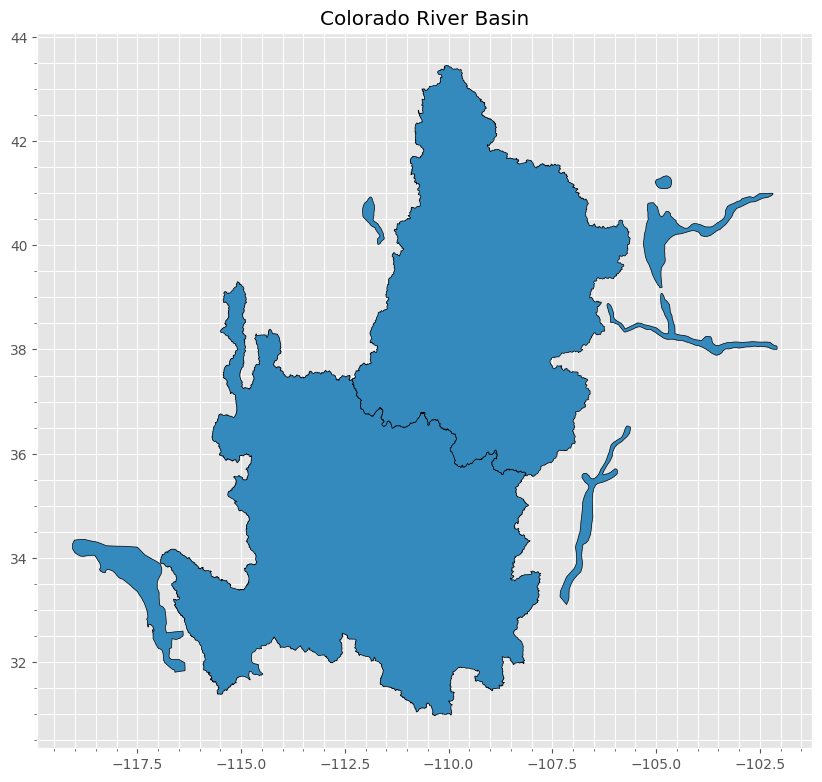

In [50]:
# Plot of entire Colorado River Basin
# Plot of entire Colorado River Basin
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=FIG_SIZE)

basin_shapefile.plot(ax=ax, alpha=1, edgecolors='black')
plt.title("Colorado River Basin")

plt.grid(which="minor")
plt.minorticks_on()
plt.show()

In [66]:
grace_df

,lon,lat,time,lwe_thickness_cm,uncertainty_cm,scale_factor,surface_area_km2,lwe_thickness_km3,uncertainty_km3
38227640,-118.75,31.25,2002-04-17 12:00:00,-0.378444,3.706507,NaN,2642.599214,NaN,0.097948
39970480,-107.75,32.25,2002-04-17 12:00:00,-0.578217,5.456031,0.589973,2614.210603,-0.008918,0.142632
39970700,-107.75,32.75,2002-04-17 12:00:00,-0.578217,5.456031,0.589973,2599.717129,-0.008868,0.141841
39970920,-107.75,33.25,2002-04-17 12:00:00,-0.578217,5.456031,0.647506,2585.025678,-0.009678,0.141040
39971140,-107.75,33.75,2002-04-17 12:00:00,-0.578217,5.456031,0.647506,2570.137366,-0.009623,0.140227
...,...,...,...,...,...,...,...,...,...
39972019,-107.75,35.25,2023-04-16 00:00:00,2.646165,3.898687,0.694992,2524.302686,0.046424,0.098415
39971799,-107.75,34.75,2023-04-16 00:00:00,2.646165,3.898687,0.373176,2539.774714,0.025080,0.099018
39971579,-107.75,34.25,2023-04-16 00:00:00,-14.812561,5.080677,0.545095,2555.053329,-0.206301,0.129814
40050559,-107.25,33.75,2023-04-16 00:00:00,-14.812561,5.080677,0.647506,2570.137366,-0.246508,0.130580


### Sanity check

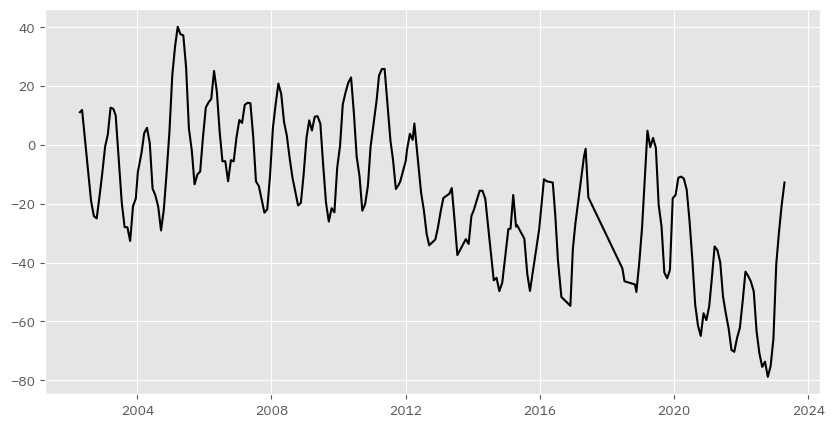

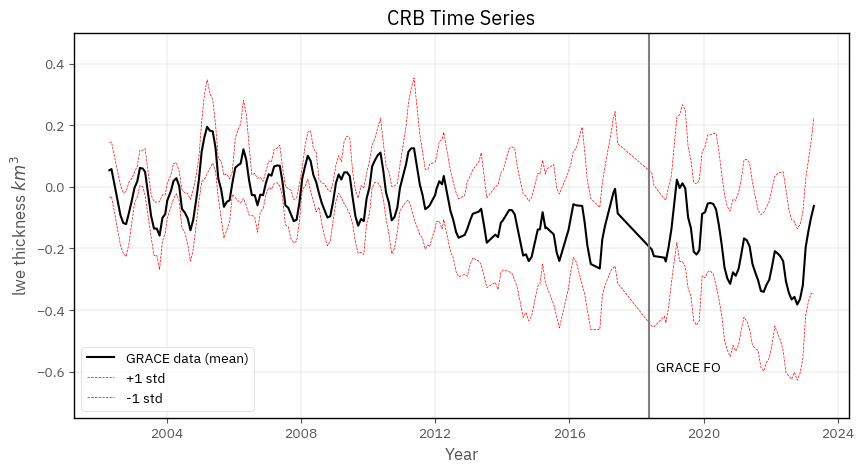

In [146]:
# Use IBM Plex when possible
plt.rcParams['font.family'] = 'IBM Plex Sans'

fig, ax = plt.subplots(figsize=(10, 5))

grouped = grace_df.groupby(['time']).mean()
grouped = grouped.reset_index()

ax.plot(grouped['time'], grouped['lwe_thickness_km3'], color='black')

ax.set_xlabel('Year')
ax.set_ylabel('lwe thickness $km^3$')
ax.set_title('CRB Time Series')

ax.set_ylim([-.75,.5])

std = grace_df.groupby(['time']).std()
std = std.reset_index()

ax.plot(std['time'], grouped['lwe_thickness_km3'] + std['lwe_thickness_km3'], color='red', linestyle='--', linewidth=0.5)
ax.plot(std['time'], grouped['lwe_thickness_km3'] - std['lwe_thickness_km3'], color='red', linestyle='--', linewidth=0.5)

# Set the date for the vertical line
vertical_line_date = '2018-05-22'

# Convert the date to datetime format
vertical_line_date = pd.to_datetime(vertical_line_date)

# Add the vertical line to the plot
ax.axvline(x=vertical_line_date, color='grey')

# Set the date for the annotation
annotationDate = '2018-08-01'

# Convert the date to datetime format
annotationDate = pd.to_datetime(annotationDate)

# Add the annotation to the plot
ax.annotate('GRACE FO', xy=(annotationDate, 0), xytext=(annotationDate, -.6), rotation=0)

# Remove the grey background
ax.set_facecolor('none')

# Add a black outline to the graph
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')

ax.set_axisbelow(True)
ax.grid(color='gray', linewidth=.125)

ax.legend(['GRACE data (mean)', '+1 std', '-1 std'], facecolor='white', loc='lower left')

# Display the plot
plt.show()




### Merging the Datasets 

Now that GRACE and GLDAS are in standardized, tabular formats, we can merge these datasets together to combine all the variables of interest and calculate groundwater estimates. S

Since the GRACE data is already filtered to the area of interest, we can simply perform a left join to merge GLDAS with GRACE data. 

In [59]:
# We begin by standardizing the time string in both datasets 
upsampled_grace_df['time'] = pd.to_datetime(upsampled_grace_df["time"].astype(str).str.slice(0, 7), format='%Y-%m')
gldas_df['time'] = pd.to_datetime(gldas_df["time"].astype(str).str.slice(0, 7), format='%Y-%m')
# Finally, we do a left join
grace_gldas_df = upsampled_grace_df.merge(gldas_df, on=["time", "lat", "lon"], how="left")

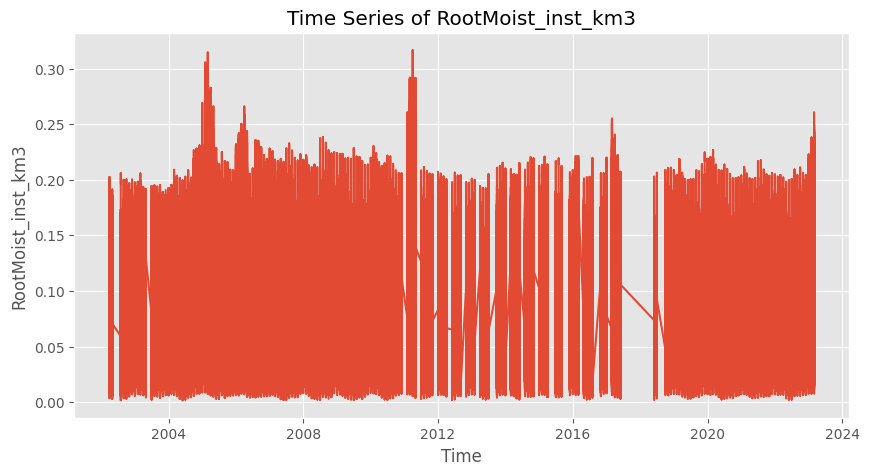

In [65]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(grace_gldas_df['time'], grace_gldas_df['RootMoist_inst_km3'])
ax.set_xlabel('Time')
ax.set_ylabel('RootMoist_inst_km3')
ax.set_title('Time Series of RootMoist_inst_km3')
plt.show()

### Calculating Anomalies  

In order to compute groundwater anomalies, you need to compute the deviation from the mean for each measurement:

$$d_i = p_i - \mu$$

where $i$ is some observation, ($d_i$) is the deviation from the mean, ($i$) is the measurement, and $\mu$ is the mean over some specified time period. 

In order to calculate $\mu$, we take the average for each parameter of interest over a specified time period. **Here, we use the time period from 2004-2009**, following NASA and recent literature, which is shown in code below. Note that the code is easily modifiable if you would like to focus on a different time period. 


In [60]:
# Filter the dataframe to include only the required dates to calculate average
TIME_PERIOD_START = '2004-01-01'
TIME_PERIOD_END = '2009-12-31'

mask = (grace_gldas_df['time'] >= TIME_PERIOD_START) & (grace_gldas_df['time'] <= TIME_PERIOD_END)
filtered_df = grace_gldas_df.loc[mask]

# Group by lat and lon and calculate average storage for the specified date range
average_df = filtered_df.groupby(['lat','lon']).agg({'SWE_inst_km3':'mean', 'RootMoist_inst_km3':'mean'}).reset_index()
average_df = average_df.rename(columns={'SWE_inst_km3':'SWE_mean_km3', 'RootMoist_inst_km3':'RootMoist_mean_km3'})

grace_gldas_df = grace_gldas_df.merge(average_df, on=['lat','lon'], how='left')

# Compute the anomaly for soil moisture and snow water equivalent
grace_gldas_df['SWE_anomaly_km3'] = grace_gldas_df['SWE_inst_km3'] - grace_gldas_df['SWE_mean_km3']
grace_gldas_df['RM_anomaly_km3'] = grace_gldas_df['RootMoist_inst_km3'] - grace_gldas_df['RootMoist_mean_km3']

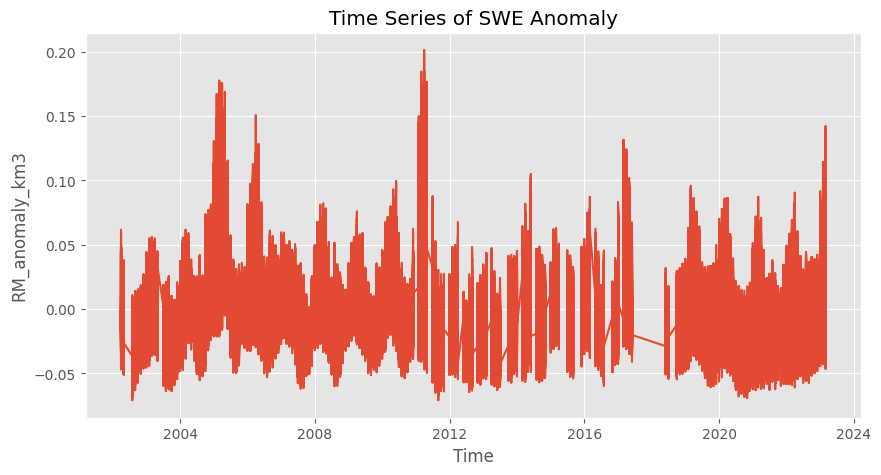

In [62]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(grace_gldas_df['time'], grace_gldas_df['RM_anomaly_km3'])
ax.set_xlabel('Time')
ax.set_ylabel('RM_anomaly_km3')
ax.set_title('Time Series of SWE Anomaly')
plt.show()
